<img src="../rsag_convex.png" alt="algoconvex" />
<img src="../x_update.png" alt="x_update" />
<img src="../mean.png" alt="mean" />
<img src="../rsag_composite.png" alt="algo" />

__Parameters :__
- $\alpha$: (1-$\alpha$) weight of aggregated x on current state, i.e. momentum
- $\lambda$: learning rate
- $\beta$: change for aggregated x
- $p_k$ termination probability



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

In [29]:
  from sklearn.model_selection import KFold
  import pandas as pd


In [3]:
import path
import sys
sys.path.append('../')
from util import DataLoader, plot_accuracies


# Data Loading

In [4]:
def preprocess_mnist():
  import random as rand


  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
  
  
  assert x_train.shape == (60000, 28, 28)
  assert x_test.shape == (10000, 28, 28)
  assert y_train.shape == (60000,)
  assert y_test.shape == (10000,)

  mean_mat = np.mean(x_train, axis=0)
  # centering the data by removing the pixel wise mean from every pixel in every image
  x_train_centered = x_train - mean_mat
  x_test_centered = x_test - mean_mat

  # normalizing the grayscale values to values in interval [0,1]
  x_train_normalized = x_train_centered/255.0
  x_test_normalized = x_test_centered/255.0

  # finally, flattening the data
  x_train = np.reshape(x_train_normalized, (60000,784))
  x_test = np.reshape(x_test_normalized, (10000, 784))
  
  #converting the test data to one hot encodings
  y_train = keras.utils.to_categorical(y_train, num_classes=10)
  y_test = keras.utils.to_categorical(y_test, num_classes=10)

  return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = preprocess_mnist()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Model Implementation - Softmax

### Metrics

In [5]:
def evaluate_acc(truth, pred):
  counter =0

  for i in range(len(pred)):
    maxVal = np.where(pred[i] == np.amax(pred[i]))
    counter += 1 if maxVal == np.where(truth[i]==1) else 0
  return counter / float(len(pred))

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

### MLP

In [6]:
#activation functions
softmax1D = lambda z: np.exp(z)/float(sum(np.exp(z)))
softmax2D = lambda z: np.array([np.exp(i)/float(sum(np.exp(i))) for i in z])
linear = lambda z: np.array([i/float(sum(i)) for i in z])
# logistic = lambda z: 1./ (1 + np.exp(-z))
# relu = lambda y: y[y <= 0]=0
def relu(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  # x[x<=0]=0.1*x
  np.putmask(x, x<0, alpha*x)
  return x
def relu_grad(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=alpha
  return x

In [7]:
class MLP_2_Layer_Softmax:

    def __init__(self, M = 128, num_classes = 10, rsag=False):
        self.M = M
        self.num_classes = num_classes
        self.rsag = rsag
        self.params = None
        self.aggr_params = None

    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            w = params[0] # v.shape = (D, M), w.shape = (M)
            z = np.dot(x, w)
            yh = softmax2D(z)#N
            dy = yh - y #N
            train_acc = evaluate_acc(y, yh)

            # Softmax Gradient
            dw = np.dot(x.T, dy)/N #M
            dparams = [dw]
            return dparams, train_acc
        
        if self.params is None:
            initializer = keras.initializers.GlorotNormal()
            w = initializer(shape=(D, self.num_classes))
            self.params = [w]
            if self.rsag:
                self.aggr_params = [np.copy(w)]
            print('params initialized')

        if self.rsag:
            self.params, self.aggr_params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params, self.aggr_params)
        else:
            self.params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params)

        return self, train_accs, batch_train_acc

    def predict(self, x):
        # print('self:',self)
        # print('self==None:',self==None)
        w = self.params[0]
        # print(w.shape)
        # z = relu(np.dot(x, w)) #N x M
        yh = softmax2D(np.dot(x, w))#N
        return yh

In [8]:
class MLP_1_Layer_Linear:

    def __init__(self, M = 128, num_classes = 10, rsag=False):
        self.M = M
        self.num_classes = num_classes
        self.rsag = rsag
        self.params = None
        self.aggr_params = None

    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            w = params[0] # v.shape = (D, M), w.shape = (M)
            z = np.dot(x, w)
            yh = linear(z)#N
            dw = np.sum(yh - y)/N #N
            train_acc = evaluate_acc(yh, y)

            # L2 Loss Gradient
            # dw = np.dot(x.T, dy)/N #M
            dparams = [dw]
            return dparams ,train_acc
        
        if self.params is None:
            initializer = keras.initializers.GlorotNormal()
            w = initializer(shape=(D, self.num_classes))
            self.params = [w]
            if self.rsag:
                self.aggr_params = [np.copy(w)]
            print('params initialized')

        if self.rsag:
            self.params, self.aggr_params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params, self.aggr_params)
        else:
            self.params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params)

        return self, train_accs, batch_train_acc

    def predict(self, x):
        # print('self:',self)
        # print('self==None:',self==None)
        w = self.params[0]

        yh = linear(np.dot(x, w))#N
        return yh

# RSAG

In [9]:
lr_lamda = lambda lr, t: lr/(1+t)

In [32]:
def train_model(model, 
                optimizer, 
                x_train, 
                y_train, 
                x_valid, 
                y_valid, 
                verbose=True, 
                print_every=10, 
                patience=20,
                save_log=False):
    # x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    # model.fit(x_train, y_train, optimizer)

    # y_test_pred = model.predict(x_valid)
    # temp_v_acc = evaluate_acc(y_test_pred, y_valid)
    # v_acc = [temp_v_acc]

    # print('acc:',temp_v_acc)
    log = {'loss': [], 'accuracy': [], 'v_loss': [], 'v_accuracy': [], 'time': []}
    t=0
    log['time'].append(time.time())
    curr_patience = 0
    accept_update = (optimizer.lr_fn is not None) or (optimizer.alpha_fn is not None) or (optimizer.beta_fn is not None)


    while t < optimizer.max_iters:
        
        model.fit(x_train, y_train, optimizer)

        log['accuracy'].append(evaluate_acc(y_train, model.predict(x_train)))
        log['loss'].append(log_loss(y_train, model.predict(x_train)))

        y_valid_pred = model.predict(x_valid)
        temp_v_acc = evaluate_acc(y_valid, y_valid_pred)
        log['v_accuracy'].append(temp_v_acc)
        log['v_loss'].append(log_loss(y_valid, y_valid_pred))
        
        if verbose:
            if t%print_every == 0:
                print('Epoch {}/{}'.format(t, optimizer.max_iters))
                print('-' * 10)
                print('Loss {:.4f}'.format(log['loss'][-1]))
                print('Accuracy:  {:.4f}'.format(log['accuracy'][-1]))
                print('Validation Loss {:.4f}'.format(log['v_loss'][-1]))
                print('Validation Accuracy:  {:.4f}'.format(log['v_accuracy'][-1]))
                print('Time :', log['time'][-1]-log['time'][0])
        
        log['time'].append(time.time())

        if len(log['v_accuracy']) > 1 and (np.abs(log['v_accuracy'][-1]-log['v_accuracy'][-2])<0.001):
            curr_patience += 1
            if curr_patience > patience:
                if accept_update:
                    optimizer.set_update_params(True)
                    curr_patience = 0
                else:
                    print('Early stopping at epoch %d'%t)
                    break
        else:
            curr_patience = 0
        t+=1
    if verbose:
        print(log)
    # if save_log == True:
    #     np.save('log.csv', log)
    return model, log, max(log['v_accuracy'])

In [11]:
class RSAG:

    def __init__(self, 
                 learning_rate=.001, 
                 alpha=0.009, 
                 beta=.000009, 
                 max_iters=200, 
                 epsilon=1e-8, 
                 batch_size=64,
                 lr_fn = None,
                    alpha_fn = None,
                    beta_fn = None,
                    start_adap = 30,
                 ):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.alpha = alpha  # momentum param
        self.beta = beta 

        self.lr_fn = lr_fn
        self.alpha_fn = alpha_fn
        self.beta_fn = beta_fn

        self.update_params = False

        self.t = 0


    def set_update_params(self, update_params):
        self.update_params = update_params

    def mini_batch_step(self, 
                       gradient_fn,
                       x, 
                       y,
                       params, 
                       agg_params,
                       batch_size=32,
                       ):
        
        train_acc, batch_train_acc, chunk = [], [], []


        slices = sklearn.utils.gen_batches(x.shape[0], batch_size)


        if self.update_params:
            print('Update params')
            if self.lr_fn is not None:
                self.learning_rate = self.lr_fn(self.learning_rate, self.t)
                # print('New learning rate:', self.learning_rate)
            if self.alpha_fn is not None:
                self.alpha = self.alpha_fn(self.alpha, self.t)
                # print('New alpha:', self.alpha)
            if self.beta_fn is not None:
                self.beta = self.beta_fn(self.beta, self.t)
                # print('New beta:', self.beta)
            self.update_params = False

        grad = None
        for batch in slices:
            x_temp, y_temp = x[batch], y[batch]

            proj_params = [(1-self.alpha) * a_p + self.alpha * p for p, a_p in zip(params, agg_params)]

            grad, temp_acc = gradient_fn(x_temp, y_temp, proj_params)

            chunk.append(temp_acc)
            train_acc.append( ( self.t, temp_acc ) )

            for p in range(len(params)):
                agg_params[p] -= self.beta * (grad[p])
                params[p] -= self.learning_rate * (grad[p])

            
        self.t += 1
            
        return params, agg_params, train_acc, batch_train_acc

# Convex

In [15]:
from sklearn.neural_network import MLPClassifier
c_clf = MLPClassifier(hidden_layer_sizes=(), activation='identity', 
                    solver='sgd', 
                    alpha=0.0001, momentum=0.8, nesterovs_momentum=True,
                    batch_size=64, 
                    learning_rate='constant', learning_rate_init=0.09, 
                    verbose=True)
%time c_clf.fit(x_train, y_train)


Iteration 1, loss = 2.04339363
Iteration 2, loss = 0.52378460
CPU times: total: 44.5 s
Wall time: 25 s


MLPClassifier(batch_size=64, hidden_layer_sizes=(512,), momentum=0.8,
              solver='sgd', verbose=True)

In [50]:
print(accuracy_score(y_test, c_clf.predict(x_test)))
# activation='relu', solver='sgd', alpha=0.0001, batch_size=64, learning_rate='constant', learning_rate_init=0.001, nesterovs_momentum=True
# [1.8023864815965787, 1.1122309566767148, 0.9845296966527957, 0.9154617448390219, 0.8699689145736055, 0.8365705881224808, 0.8107982315381743, 0.7895384784268797, 0.771082085742921, 0.7552732548141347, 0.7415558847414158, 0.7287698625332969, 0.7172472639691361, 0.706809744230456, 0.697198112331996, 0.6880630036115248, 0.6799326487354387, 0.6720643946144156, 0.6646984452814398, 0.6576804957640667, 0.6510529769693165, 0.6446246119656461]
# 0.8017
# CPU times: total: 7min 10s
# Wall time: 3min 44s
# solver='adam', alpha=0.0001, batch_size=64, learning_rate='constant', learning_rate_init=0.001, nesterovs_momentum=True,verbose=True)
# 84.57
# [0.8612156609999259, 0.6249129242272599, 0.5581398511623741, 0.5108802118568585, 0.4691072568910733, 0.4353992497295652, 0.40704429576434176, 0.3805020388852907, 0.35406887324687, 0.3298601532867995, 0.30623046652949937, 0.29002717397885547, 0.2713237669144441, 0.2514935455522592, 0.23837528939129574, 0.22462548777331365, 0.2122725128906315, 0.19964016897140632, 0.18637880570153922, 0.17356588508840962, 0.1658213505209685, 0.15647343628720575, 0.14783796049234926, 0.1333524127764709, 0.14204921604363624, 0.12750238350269527, 0.11881357392933954, 0.11200988128682542, 0.1130529385547876, 0.11354326204537345, 0.09885686873471046, 0.0930096509081991, 0.09655665834549663, 0.09260154624164536, 0.08115000406704216, 0.07959780062782788, 0.08250181458817121, 0.08106108561985036, 0.07341696734054892, 0.07604154997056141, 0.06295011133958502, 0.08018669386804467, 0.0616817261430883, 0.07367609626831328, 0.06523213700827496, 0.06964252739224731, 0.05752994633281319, 0.05197989734371084, 0.07381226348438415, 0.05830003207888134, 0.059422724682382105, 0.05041107174843518, 0.05727327599541805, 0.045635822816795256, 0.07568988410558206, 0.051876567841403196, 0.046329602952653766, 0.05991002631492367, 0.053050026014173995, 0.05121909793694829, 0.05788941712186149, 0.043738605256584066, 0.062191099081914634, 0.040420605015593726, 0.04949669605103939, 0.05005099457912783, 0.046754105687687286, 0.055313401757353574, 0.031450249271437095, 0.07335947120026465, 0.03956862519001744, 0.0557280472207543, 0.04982615933858711, 0.05109769744532108, 0.04067857278228474, 0.03421287144297862, 0.05925097099087448, 0.04785653973425865, 0.03998925377281498, 0.04366581677240043]

0.8017


In [89]:
model = MLP_1_Layer_Linear(M=128, num_classes=10, rsag=True)
optimizer = RSAG(learning_rate=.09, alpha=0.009, beta=0.00009, lr_fn=lr_lamda, alpha_fn=lr_lamda, beta_fn=lr_lamda, start_adap=49)

model, log, acc_max = train_model(model, optimizer, x_train, y_train, x_valid, y_valid, print_every=10)

params initialized
Epoch 0/200
----------
Loss 17.4952
Accuracy:  0.0000
Validation Loss 17.2828
Validation Accuracy:  0.0000
Time : 0.0


KeyboardInterrupt: 

In [95]:
model = MLP_1_Layer_Linear(M=128, num_classes=10, rsag=True)
optimizer = RSAG(learning_rate=.09, alpha=0.009, beta=0.00009, lr_fn=lr_lamda, alpha_fn=lr_lamda, beta_fn=lr_lamda, start_adap=49)

model, log, acc_max = train_model(model, optimizer, x_train, y_train, x_valid, y_valid, print_every=10)

params initialized
Epoch 0/200
----------
Loss 14.7551
Accuracy:  0.1216
Validation Loss 14.7445
Validation Accuracy:  0.1266
Time : 0.0
Epoch 10/200
----------
Loss 14.7551
Accuracy:  0.1216
Validation Loss 14.7445
Validation Accuracy:  0.1266
Time : 30.225996255874634


KeyboardInterrupt: 

# Non-Convex

## Constant Learning Rate

In [ ]:
from sklearn.neural_network import MLPClassifier
adam_clf = MLPClassifier(hidden_layer_sizes=(512,), activation='relu', solver='adam', alpha=0.0001, momentum=0.8, batch_size=64, learning_rate='constant', learning_rate_init=0.09, nesterovs_momentum=True,verbose=True)
%time adam_clf.fit(x_train, y_train)
print(adam_clf)

In [70]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(512,), activation='relu', solver='sgd', alpha=0.0001, momentum=0.8, batch_size=64, learning_rate='constant', learning_rate_init=0.09, nesterovs_momentum=True,verbose=True)
%time clf.fit(x_train, y_train)

Iteration 1, loss = 0.45144808
Iteration 2, loss = 0.20030202
Iteration 3, loss = 0.13861566
Iteration 4, loss = 0.10182641
Iteration 5, loss = 0.07576465
Iteration 6, loss = 0.05712919
Iteration 7, loss = 0.04323124
Iteration 8, loss = 0.03155732
Iteration 9, loss = 0.02423139
Iteration 10, loss = 0.01871788
Iteration 11, loss = 0.01531092
Iteration 12, loss = 0.01264694
Iteration 13, loss = 0.01075438
Iteration 14, loss = 0.00947037
Iteration 15, loss = 0.00827882
Iteration 16, loss = 0.00756713
Iteration 17, loss = 0.00694991
Iteration 18, loss = 0.00643158
Iteration 19, loss = 0.00595323
Iteration 20, loss = 0.00565800
Iteration 21, loss = 0.00535291
Iteration 22, loss = 0.00507294
Iteration 23, loss = 0.00488000
Iteration 24, loss = 0.00465542
Iteration 25, loss = 0.00448840
Iteration 26, loss = 0.00436394
Iteration 27, loss = 0.00421457
Iteration 28, loss = 0.00408843
Iteration 29, loss = 0.00399359
Iteration 30, loss = 0.00389515
Iteration 31, loss = 0.00379460
Iteration 32, los

MLPClassifier(batch_size=64, hidden_layer_sizes=(512,), learning_rate_init=0.09,
              momentum=0.8, solver='sgd', verbose=True)

In [97]:
model = MLP_2_Layer_Softmax(M=128, num_classes=10, rsag=True)
optimizer = RSAG(learning_rate=.08, alpha=0.009, beta=0.0009)
model, log, acc_max = train_model(model, optimizer, x_train, y_train, x_valid, y_valid, print_every=10)

params initialized
Epoch 0/200
----------
Loss 2.2549
Accuracy:  0.1478
Validation Loss 2.2535
Validation Accuracy:  0.1478
Time : 0.0
Epoch 10/200
----------
Loss 1.5257
Accuracy:  0.6403
Validation Loss 1.5279
Validation Accuracy:  0.6391
Time : 31.632031440734863
Epoch 20/200
----------
Loss 1.1125
Accuracy:  0.7077
Validation Loss 1.1151
Validation Accuracy:  0.7047
Time : 63.96003222465515
Epoch 30/200
----------
Loss 0.9175
Accuracy:  0.7224
Validation Loss 0.9203
Validation Accuracy:  0.7215
Time : 96.51003050804138
Epoch 40/200
----------
Loss 0.8393
Accuracy:  0.7273
Validation Loss 0.8430
Validation Accuracy:  0.7267
Time : 129.29102683067322
Epoch 50/200
----------
Loss 0.8228
Accuracy:  0.7295
Validation Loss 0.8280
Validation Accuracy:  0.7298
Time : 162.48103308677673
Early stopping at epoch 56
{'loss': [2.2548951593048785, 2.1681448416511957, 2.084150150450492, 2.003054597431855, 1.924995940079093, 1.8500990655938359, 1.7784685347480476, 1.7101829061236276, 1.64529019096

In [81]:
print('Nesterov\'s Momentum: ', accuracy_score(y_test, clf.predict(x_test)))
# print('Adam', adam_clf.eval_acc(x_test, y_test))
print('RSAG: ', evaluate_acc(y_test, model.predict(x_test)))
# Nesterov's Momentum:  0.9665
# RSAG:  0.7206
# {'loss': [2.357493262704862, 2.3471664639089758, 2.336871564699908, 2.3266087629948156, 2.3163782663969625, 2.306180261969263, 2.296014954792932, 2.2858825514370684, 2.275783276062723, 2.2657173287436483, 2.2556849100078917, 2.2456862319197106, 2.2357215177010676, 2.2257909599465244, 2.2158947770600275, 2.2060331973150737, 2.196206441997492, 2.1864147096406477, 2.176658217864617, 2.1669371854196693, 2.157251819200863, 2.14760234162527, 2.137988972627998, 2.1284119197860307, 2.118871425117049, 2.109367674948375, 2.0999008857870667, 2.090471269311462, 2.08107904117874, 2.0717244160673745, 2.0624075955401304, 2.0531287910323406, 2.04388826380772, 2.0346861655173676, 2.0255226950944136, 2.0163980549045832, 2.0073124405917144, 1.9982660519594215, 1.9892590871820437, 1.9802917504084085, 1.9713642381485412, 1.9624767285533795, 1.9536294092370041, 1.9448224721737466, 1.9360560871976538, 1.927330438909241, 1.9186457078648194, 1.9100020793230257, 1.9013996939811455, 1.8928387139891918, 1.8843192982920383, 1.8758416041721995, 1.867405786634906, 1.8590119973651469, 1.8506603741164986, 1.8423510708487176, 1.8340842025822006, 1.8258598867168763, 1.8176782536714275, 1.8095394062750911, 1.8014434603255238, 1.7933905253239064, 1.7853807145097298, 1.77741413657924, 1.7694908570719345, 1.761610974587742, 1.7537745600777388, 1.745981711821348, 1.7382324795136586, 1.7305269323037258, 1.7228651379315445, 1.7152471544864067, 1.7076730185872229, 1.7001427764456825, 1.692656461394606, 1.685214114127181, 1.6778157432326959, 1.6704613852950891, 1.663151042325173, 1.6558847239251082, 1.6486624205084093, 1.6414841584081972, 1.634349925091247, 1.6272597036491694, 1.6202134840268336, 1.613211239475934, 1.6062529404694201, 1.599338549310541, 1.5924680306813344, 1.5856413422482407, 1.5788584306457842, 1.5721192430191588, 1.5654237257144978, 1.5587718117003326, 1.552163438485007, 1.5455985356840478, 1.539077018356512, 1.5325988192898454, 1.5261638526559544, 1.5197720257093084, 1.5134232479389964, 1.5071174298821348, 1.5008544654452682, 1.4946342470550513, 1.4884566597806794, 1.482321605227411, 1.4762289688978025, 1.470178623328491, 1.4641704381432095, 1.458204291786358, 1.452280058499483, 1.4463976093343172, 1.4405568138450227, 1.4347575358249771, 1.4289996230858726, 1.4232829289511146, 1.4176073120800945, 1.4119726269764141, 1.4063787157941727, 1.4008254311498027, 1.3953126101865407, 1.3898401094373254, 1.3844077445091605, 1.3790153681629478, 1.373662804813439, 1.3683498867817576, 1.363076448688257, 1.3578423279983778, 1.352647343813666, 1.347491321779183, 1.3423740796751333, 1.3372954394044785, 1.332255223853742, 1.3272532568189093, 1.3222893615117548, 1.3173633443465387, 1.3124750242808674, 1.307624207317904, 1.3028107069865984, 1.298034345636163, 1.2932949311900148, 1.2885922710110211, 1.2839261762429317, 1.2792964573220336, 1.2747029192256465, 1.2701453703025112, 1.2656236179953457, 1.2611374637325692, 1.2566867099515513, 1.2522711703236982, 1.2478906349710015, 1.2435449073574296, 1.2392337982222992, 1.2349571140146063, 1.230714658922692, 1.2265062404549303, 1.2223316460218046, 1.218190686900038, 1.2140831605096771, 1.2100088684362353, 1.2059676134426724, 1.2019591867520412, 1.1979833987161441, 1.19404005150336, 1.190128946267287, 1.1862498786299527], 'accuracy': [7.954166666666667, 8.35625, 8.808333333333334, 9.4125, 9.929166666666667, 10.495833333333334, 11.175, 11.78125, 12.425, 13.064583333333333, 13.789583333333333, 14.554166666666667, 15.375, 16.2, 17.072916666666668, 17.897916666666667, 18.772916666666667, 19.697916666666668, 20.589583333333334, 21.527083333333334, 22.46875, 23.5125, 24.516666666666666, 25.54375, 26.502083333333335, 27.408333333333335, 28.414583333333333, 29.485416666666666, 30.414583333333333, 31.447916666666668, 32.46458333333333, 33.39791666666667, 34.260416666666664, 35.233333333333334, 36.1125, 36.96458333333333, 37.87291666666667, 38.7125, 39.483333333333334, 40.21041666666667, 40.99791666666667, 41.76875, 42.50416666666667, 43.2, 43.916666666666664, 44.56041666666667, 45.24166666666667, 45.90625, 46.5625, 47.175, 47.75625, 48.30625, 48.87708333333333, 49.422916666666666, 50.00833333333333, 50.577083333333334, 51.13125, 51.6875, 52.229166666666664, 52.75833333333333, 53.2625, 53.77708333333333, 54.21458333333333, 54.65416666666667, 55.1125, 55.608333333333334, 56.00416666666667, 56.37708333333333, 56.775, 57.114583333333336, 57.427083333333336, 57.77291666666667, 58.18125, 58.514583333333334, 58.8375, 59.1375, 59.46458333333333, 59.75, 60.03541666666667, 60.27291666666667, 60.52916666666667, 60.766666666666666, 61.05416666666667, 61.3, 61.5, 61.76875, 62.02708333333333, 62.275, 62.51875, 62.71041666666667, 62.925, 63.15416666666667, 63.36666666666667, 63.59166666666667, 63.78333333333333, 63.979166666666664, 64.16458333333334, 64.35833333333333, 64.51875, 64.68958333333333, 64.83333333333333, 64.99375, 65.13541666666667, 65.31458333333333, 65.49166666666666, 65.66041666666666, 65.80625, 65.97083333333333, 66.13125, 66.24166666666666, 66.38125, 66.5375, 66.675, 66.76458333333333, 66.90625, 67.04166666666667, 67.17708333333333, 67.2875, 67.39791666666666, 67.52708333333334, 67.64791666666666, 67.76666666666667, 67.8875, 67.99583333333334, 68.11041666666667, 68.2375, 68.3625, 68.46666666666667, 68.5875, 68.68541666666667, 68.75833333333334, 68.83958333333334, 68.94375, 69.04166666666667, 69.10416666666667, 69.19583333333334, 69.27291666666666, 69.34166666666667, 69.40416666666667, 69.47083333333333, 69.4875, 69.575, 69.63958333333333, 69.69583333333334, 69.75208333333333, 69.78958333333334, 69.85416666666667, 69.92083333333333, 70.00416666666666, 70.0625, 70.11458333333333, 70.16666666666667, 70.20833333333333, 70.25833333333334, 70.30416666666666, 70.34791666666666, 70.39166666666667, 70.43125, 70.49583333333334, 70.53333333333333, 70.59791666666666, 70.64583333333333, 70.7, 70.76666666666667, 70.79791666666667, 70.84583333333333], 'v_loss': [2.3575893921522804, 2.347310633922136, 2.3370634920179945, 2.326848160651769, 2.3166648412814554, 2.306513717011736, 2.296394988167253, 2.286308856368212, 2.276255540847012, 2.266235235048125, 2.2562481364534883, 2.246294452155379, 2.2363743996404275, 2.2264881680363025, 2.216635970401511, 2.20681803162157, 2.1970345675767, 2.1872857715673923, 2.1775718567336466, 2.167893037909416, 2.158249517188516, 2.1486415123311926, 2.139069239120084, 2.1295329003857835, 2.120032732951087, 2.110568919251057, 2.10114167129062, 2.0917511965640183, 2.0823977065829884, 2.0730814113331273, 2.063802509355281, 2.0545612078299014, 2.045357763425631, 2.0361923237160995, 2.027065084029318, 2.0179762429591896, 2.008925991929431, 1.999914527193297, 1.9909420435097551, 1.9820087415491647, 1.9731148130100646, 1.9642604341411618, 1.9554457883983836, 1.9466710634871287, 1.9379364261071441, 1.9292420573227032, 1.9205881346975124, 1.911974840416999, 1.903402311685569, 1.8948707079207263, 1.8863801850373074, 1.8779308977198543, 1.8695229975179604, 1.8611566345121597, 1.8528319435511784, 1.8445490756004295, 1.836308143303213, 1.8281092624004456, 1.819952560644179, 1.8118381386216897, 1.803766110754626, 1.7957365837595116, 1.7877496699548294, 1.7798054766253617, 1.771904067165392, 1.7640455394284453, 1.7562299633154403, 1.748457435707695, 1.7407280062816715, 1.733041743490038, 1.7253987133835744, 1.7177989746893734, 1.7102425633743223, 1.7027295262894526, 1.6952598965434509, 1.6878337151579423, 1.680450991739085, 1.6731117644232696, 1.6658160359868064, 1.6585638174963937, 1.6513551006594516, 1.6441899124678154, 1.6370682427881853, 1.6299900763502821, 1.622955406002054, 1.6159642077312644, 1.6090164546128527, 1.6021121127681675, 1.59525114849903, 1.5884335238968494, 1.5816591883205469, 1.574928092637531, 1.568240187742883, 1.5615954107350374, 1.5549937033055397, 1.548434999392862, 1.5419192194640878, 1.5354463006606045, 1.5290161624494643, 1.5226287171728767, 1.5162838801632545, 1.509981567416252, 1.5037216782541782, 1.4975041109779026, 1.4913287569705316, 1.4851955246012383, 1.4791043053045678, 1.4730549777893571, 1.4670474183422764, 1.4610815129268862, 1.4551571421047722, 1.449274183704767, 1.4434325135988877, 1.4376320020914257, 1.4318725056548207, 1.4261538841092205, 1.4204760024431358, 1.4148387234280078, 1.409241896222079, 1.4036853816404897, 1.3981690245772582, 1.3926926887320712, 1.387256196861038, 1.3818594093958394, 1.3765021584859793, 1.371184283588369, 1.36590562702681, 1.360666033338891, 1.3554653293092178, 1.3503033481473847, 1.3451799142159577, 1.3400948576971714, 1.3350480088359895, 1.3300391985072253, 1.3250682575499002, 1.3201349986918638, 1.3152392493373128, 1.3103808212758619, 1.305559536424419, 1.3007752240926898, 1.2960276992792057, 1.2913167759910609, 1.2866422718990236, 1.2820040043449357, 1.2774017852257296, 1.2728354291292547, 1.2683047503689577, 1.2638095570498964, 1.2593496576501206, 1.2549248722624788, 1.2505349971060384, 1.246179841166178, 1.2418592220949032, 1.2375729523946908, 1.2333208419269788, 1.2291027038451399, 1.2249183312797363, 1.2207675404406864, 1.2166501348022476, 1.2125659213436153, 1.2085147076273997, 1.2044962903274274, 1.2005104852997213, 1.1965570992855818, 1.1926359378376434, 1.1887468023454533], 'v_accuracy': [8.008333333333333, 8.4, 8.833333333333334, 9.366666666666667, 9.95, 10.508333333333333, 11.083333333333334, 11.625, 12.233333333333333, 12.841666666666667, 13.55, 14.316666666666666, 15.025, 15.825, 16.591666666666665, 17.4, 18.416666666666668, 19.308333333333334, 20.166666666666668, 21.116666666666667, 22.175, 23.183333333333334, 24.166666666666668, 25.175, 26.35, 27.508333333333333, 28.691666666666666, 29.666666666666668, 30.533333333333335, 31.458333333333332, 32.391666666666666, 33.40833333333333, 34.425, 35.233333333333334, 36.18333333333333, 36.99166666666667, 37.84166666666667, 38.641666666666666, 39.4, 40.05833333333333, 40.94166666666667, 41.625, 42.275, 43.05, 43.71666666666667, 44.333333333333336, 44.983333333333334, 45.666666666666664, 46.166666666666664, 46.775, 47.30833333333333, 47.925, 48.50833333333333, 49.06666666666667, 49.766666666666666, 50.31666666666667, 50.88333333333333, 51.43333333333333, 51.96666666666667, 52.416666666666664, 52.916666666666664, 53.391666666666666, 53.925, 54.541666666666664, 55.016666666666666, 55.416666666666664, 55.81666666666667, 56.2, 56.69166666666667, 57.19166666666667, 57.63333333333333, 58.0, 58.333333333333336, 58.583333333333336, 58.858333333333334, 59.28333333333333, 59.516666666666666, 59.666666666666664, 59.975, 60.28333333333333, 60.45, 60.69166666666667, 60.94166666666667, 61.2, 61.49166666666667, 61.81666666666667, 62.141666666666666, 62.358333333333334, 62.608333333333334, 62.78333333333333, 63.025, 63.3, 63.46666666666667, 63.7, 63.86666666666667, 64.13333333333334, 64.35, 64.59166666666667, 64.85, 65.0, 65.225, 65.375, 65.54166666666667, 65.71666666666667, 65.9, 66.06666666666666, 66.2, 66.31666666666666, 66.425, 66.66666666666667, 66.75833333333334, 66.95833333333333, 67.125, 67.26666666666667, 67.4, 67.525, 67.64166666666667, 67.7, 67.84166666666667, 67.9, 67.94166666666666, 68.025, 68.21666666666667, 68.3, 68.43333333333334, 68.50833333333334, 68.625, 68.71666666666667, 68.80833333333334, 68.90833333333333, 68.94166666666666, 68.98333333333333, 69.09166666666667, 69.21666666666667, 69.30833333333334, 69.425, 69.475, 69.53333333333333, 69.55, 69.675, 69.71666666666667, 69.825, 69.85833333333333, 69.91666666666667, 70.025, 70.10833333333333, 70.19166666666666, 70.225, 70.275, 70.31666666666666, 70.35833333333333, 70.39166666666667, 70.40833333333333, 70.41666666666667, 70.45833333333333, 70.525, 70.56666666666666, 70.59166666666667, 70.61666666666666, 70.675, 70.725, 70.75833333333334, 70.79166666666667, 70.79166666666667, 70.84166666666667, 70.85833333333333], 'time': [1703949600.870197, 1703949604.2891946, 1703949607.9621935, 1703949611.3631942, 1703949614.7471917, 1703949617.9801943, 1703949621.374193, 1703949624.6571922, 1703949627.8852284, 1703949631.1401927, 1703949634.440192, 1703949637.755196, 1703949640.9302123, 1703949644.2072084, 1703949647.617213, 1703949651.0732124, 1703949654.1662095, 1703949657.228212, 1703949660.3032446, 1703949663.3462086, 1703949666.4732094, 1703949669.5592127, 1703949672.7642465, 1703949675.981247, 1703949679.0772462, 1703949682.1612139, 1703949685.2292452, 1703949688.4192088, 1703949691.5182106, 1703949694.622209, 1703949697.7012095, 1703949700.811209, 1703949703.9202132, 1703949707.01221, 1703949710.0942118, 1703949713.1722128, 1703949716.316213, 1703949719.4232092, 1703949722.5292494, 1703949725.6572127, 1703949728.764246, 1703949731.8712091, 1703949734.9422116, 1703949738.0562088, 1703949741.1372123, 1703949744.2712097, 1703949747.3732138, 1703949750.4662101, 1703949753.5272462, 1703949756.619209, 1703949759.7262504, 1703949762.7842112, 1703949765.8442092, 1703949768.9062464, 1703949772.0172083, 1703949775.146211, 1703949778.2582088, 1703949781.3812091, 1703949784.4672089, 1703949787.604209, 1703949790.7322457, 1703949793.8202085, 1703949796.9112086, 1703949800.0262456, 1703949803.128211, 1703949806.2102091, 1703949809.3052454, 1703949812.3732102, 1703949815.4772086, 1703949818.5282092, 1703949821.6342108, 1703949824.708213, 1703949827.8092139, 1703949830.9252455, 1703949833.9842122, 1703949837.0302088, 1703949840.1402447, 1703949843.272247, 1703949846.3422132, 1703949849.489209, 1703949852.5662122, 1703949855.6642087, 1703949858.7602432, 1703949861.8782089, 1703949865.075245, 1703949868.176209, 1703949871.247246, 1703949874.3412118, 1703949877.4662087, 1703949880.5482125, 1703949883.6712096, 1703949886.749246, 1703949889.8522127, 1703949892.9892104, 1703949896.2372112, 1703949899.3602087, 1703949902.44121, 1703949905.535209, 1703949908.7172127, 1703949911.8302445, 1703949914.9142094, 1703949918.0082095, 1703949921.1202126, 1703949924.2332091, 1703949927.3172116, 1703949930.4642491, 1703949933.577208, 1703949936.638209, 1703949939.7592454, 1703949942.8562453, 1703949945.9522111, 1703949949.0382087, 1703949952.1482441, 1703949955.3052456, 1703949958.615209, 1703949961.709245, 1703949965.0152457, 1703949968.5502093, 1703949972.0512455, 1703949975.6682117, 1703949979.795208, 1703949983.5702472, 1703949987.000211, 1703949990.7862089, 1703949994.0822477, 1703949998.1162117, 1703950002.0132096, 1703950005.630247, 1703950009.0662143, 1703950012.5982094, 1703950016.4362466, 1703950020.1952114, 1703950023.846209, 1703950027.818215, 1703950031.4872096, 1703950035.1532118, 1703950038.6392157, 1703950041.9772122, 1703950045.5602083, 1703950049.5952094, 1703950053.21621, 1703950056.877248, 1703950060.6822133, 1703950064.2012088, 1703950067.8502438, 1703950071.5822124, 1703950075.5992086, 1703950079.430245, 1703950082.9082105, 1703950086.534209, 1703950089.9962504, 1703950093.2852128, 1703950096.6192133, 1703950099.7932086, 1703950103.009247, 1703950106.2172093, 1703950109.4372087, 1703950112.5972087, 1703950115.7562113, 1703950118.8942108, 1703950122.1032088, 1703950125.285214, 1703950128.515213, 1703950131.686213, 1703950134.841213, 1703950138.0182126, 1703950141.2102091]}


Nesterov's Momentum:  0.9665
RSAG:  0.7206


## Adaptive Rates

In [98]:
from sklearn.neural_network import MLPClassifier
ada_nc_clf = MLPClassifier(hidden_layer_sizes=(512,), 
                    activation='relu', 
                    solver='sgd', 
                    nesterovs_momentum=True, momentum=0.8, 
                    alpha=0.0001, 
                    batch_size=64, 
                    learning_rate='adaptive', learning_rate_init=0.09, 
                    verbose=True)
%time ada_nc_clf.fit(x_train, y_train)
print(ada_nc_clf.loss_curve_)
# [0.44681103581513676, 0.20019664490280964, 0.13903224539205372, 0.10424847724141931, 0.07820499920454431, 0.058752163212104365, 0.043410302283061385, 0.03309851304613901, 0.024876101979232398, 0.01929008625679405, 0.015819937931698343, 0.013119976535614704, 0.010973030088508333, 0.009540544547209177, 0.008448110407638392, 0.007664338032747635, 0.007013316780792199, 0.006486374157175714, 0.006095292770812613, 0.005675877345495901, 0.0054022429375176085, 0.00513810528301851, 0.004894300819477778, 0.0046914968425572304, 0.004521968420409352, 0.004382123050836891, 0.004225336735758417, 0.004105947003241883, 0.004022477045464209, 0.00391625698267327, 0.00381627076430297, 0.003734125082134867, 0.0036585145164223704, 0.0035892765943956887, 0.003535108147590659, 0.0034728889894520094, 0.003423243203272597, 0.0033613748221156515, 0.0033209246686070446, 0.0032750012111578595, 0.0032428164285514404, 0.0031472642626693514, 0.00313540047623953, 0.0031274728038711342, 0.0031212632827213012, 0.003114252978888586, 0.0031080337824674776, 0.003101702468251574, 0.0030953610962955085, 0.0030896990514066754, 0.0030833365283901883, 0.0030782073457771234, 0.0030617350283354996, 0.003060549141933265, 0.0030593253836724964, 0.0030581476059231704, 0.0030570752884987, 0.0030559063233432083, 0.0030547919126509217, 0.0030536457900612515, 0.003052595325926041, 0.003051489594663097, 0.003050402807525037, 0.003047089985460461, 0.0030468709101408916, 0.00304664551618608, 0.0030464373152081815, 0.0030462080789324364, 0.0030459880671757436, 0.0030457771840295507, 0.003045556586654198, 0.0030453388259683405, 0.003045121461271467, 0.0030449053634260008, 0.003044243744314005, 0.003044199859050067, 0.0030441554267542706, 0.003044113223247068, 0.0030440669153180746, 0.003044024809002121, 0.0030439809670705074, 0.003043937660844538, 0.003043893460652599, 0.0030438492201060137, 0.0030438063584988352, 0.0030436746449449643, 0.0030436661456755966, 0.003043657153375949, 0.0030436483079828943, 0.0030436399384663215, 0.003043631149097291, 0.0030436226278294947, 0.0030436140071533023, 0.0030436051023823587, 0.003043596657471788, 0.0030435877939500645, 0.0030435612724777723, 0.003043559480786767, 0.0030435576795176137, 0.0030435559909718557, 0.0030435543156908484, 0.0030435524919245087, 0.0030435508733789004, 0.0030435490561886423, 0.0030435473792563687, 0.0030435455905639722, 0.003043543878271781, 0.003043538543579084, 0.003043538195354039, 0.0030435378405210514, 0.003043537500316023, 0.003043537158119788, 0.0030435368009090824, 0.0030435364589390434, 0.0030435361249210625, 0.003043535774513943, 0.0030435354281969276, 0.003043535068763328, 0.003043534007049275, 0.0030435339380192826, 0.0030435338680986786, 0.003043533801818329, 0.0030435337274862567, 0.0030435336587934713, 0.003043533590966916, 0.0030435335231968684, 0.0030435334535933857, 0.0030435333838051744, 0.0030435333118708843]

Iteration 1, loss = 0.44681104
Iteration 2, loss = 0.20019664
Iteration 3, loss = 0.13903225
Iteration 4, loss = 0.10424848
Iteration 5, loss = 0.07820500
Iteration 6, loss = 0.05875216
Iteration 7, loss = 0.04341030
Iteration 8, loss = 0.03309851
Iteration 9, loss = 0.02487610
Iteration 10, loss = 0.01929009
Iteration 11, loss = 0.01581994
Iteration 12, loss = 0.01311998
Iteration 13, loss = 0.01097303
Iteration 14, loss = 0.00954054
Iteration 15, loss = 0.00844811
Iteration 16, loss = 0.00766434
Iteration 17, loss = 0.00701332
Iteration 18, loss = 0.00648637
Iteration 19, loss = 0.00609529
Iteration 20, loss = 0.00567588
Iteration 21, loss = 0.00540224
Iteration 22, loss = 0.00513811
Iteration 23, loss = 0.00489430
Iteration 24, loss = 0.00469150
Iteration 25, loss = 0.00452197
Iteration 26, loss = 0.00438212
Iteration 27, loss = 0.00422534
Iteration 28, loss = 0.00410595
Iteration 29, loss = 0.00402248
Iteration 30, loss = 0.00391626
Iteration 31, loss = 0.00381627
Iteration 32, los

MLPClassifier(batch_size=64, hidden_layer_sizes=(512,),
              learning_rate='adaptive', learning_rate_init=0.09, momentum=0.8,
              solver='sgd', verbose=True)

In [17]:
ada_nc_model = MLP_2_Layer_Softmax(M=128, num_classes=10, rsag=True)
optimizer = RSAG(learning_rate=.09, alpha=0.009, beta=0.00009,
                lr_fn=lr_lamda, alpha_fn=lr_lamda, beta_fn=lr_lamda, 
                start_adap=49)
%time ada_nc_model, ada_nc_log, acc_max = train_model(ada_nc_model, optimizer, x_train, y_train, x_valid, y_valid, print_every=10)

params initialized
Epoch 0/200
----------
Loss 2.2858
Accuracy:  0.1419
Validation Loss 2.2843
Validation Accuracy:  0.1423
Time : 0.0
Epoch 10/200
----------
Loss 1.4711
Accuracy:  0.6388
Validation Loss 1.4738
Validation Accuracy:  0.6418
Time : 30.267032146453857
Epoch 20/200
----------
Loss 1.0591
Accuracy:  0.7058
Validation Loss 1.0616
Validation Accuracy:  0.7088
Time : 60.39199757575989
Epoch 30/200
----------
Loss 0.8980
Accuracy:  0.7189
Validation Loss 0.9004
Validation Accuracy:  0.7182
Time : 90.4540319442749
Epoch 40/200
----------
Loss 0.8574
Accuracy:  0.7201
Validation Loss 0.8608
Validation Accuracy:  0.7198
Time : 120.69400072097778
Update params
Epoch 50/200
----------
Loss 0.8646
Accuracy:  0.7194
Validation Loss 0.8689
Validation Accuracy:  0.7192
Time : 150.87800192832947
Epoch 60/200
----------
Loss 0.8651
Accuracy:  0.7194
Validation Loss 0.8695
Validation Accuracy:  0.7192
Time : 180.9679982662201
Update params
Epoch 70/200
----------
Loss 0.8655
Accuracy:  0.

In [113]:
print('Nesterov\'s Momentum: ', accuracy_score(y_test, ada_nc_clf.predict(x_test)))
print('RSAG: ', evaluate_acc(y_test, ada_nc_model.predict(x_test)))

Nesterov's Momentum:  0.9662
RSAG:  0.7395


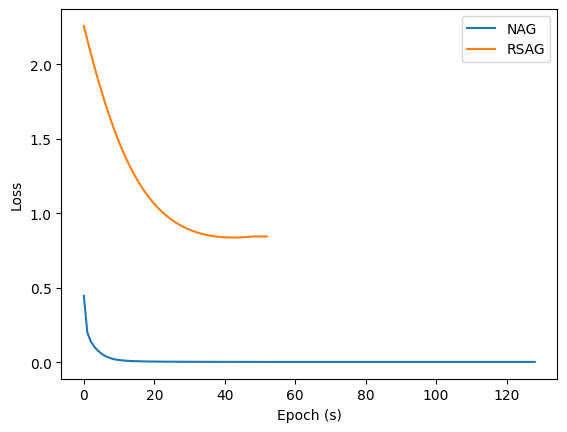

In [120]:
plot_accuracies([ada_nc_clf.loss_curve_, log['v_loss']], ['NAG', 'RSAG'])

# Plots

In [118]:
def plot_accuracies(logs, labels):
    for log, label in zip(logs,labels):
        plt.plot(range(len(log)), log, label=label)
        plt.xlabel('Epoch (s)')
        plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracies_vs_time(logs):
    for log in logs:
        plt.plot(log['v_accuracy'], log['time'], label=log['label'])
        plt.xlabel('Time (s)')
        plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

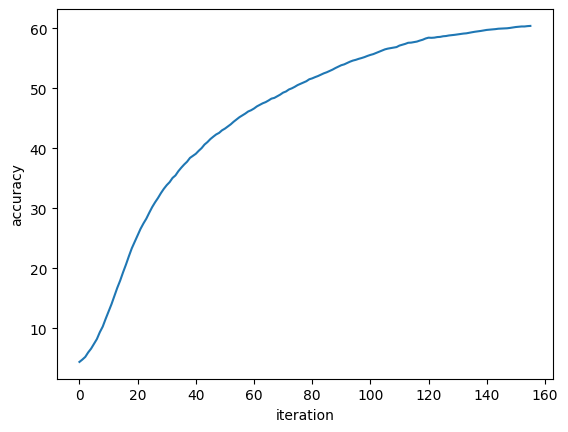

In [41]:
plot_accuracies(log['v_accuracy'])

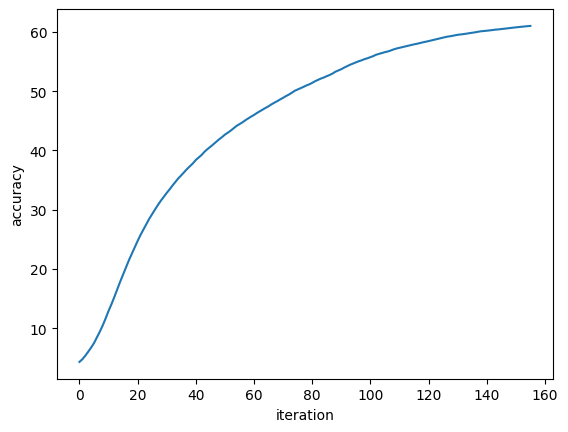

In [42]:
plot_accuracies(log['accuracy'])

In [ ]:
#earning_rate=.006, alpha=0.009, beta=0.000009 {'loss': [2.5160519958632497, 2.4973575056239055, 2.478812720935548, 2.460418367816293, 2.4421750728527756, 2.424083243209927, 2.406143218943164, 2.388355619024832, 2.370720531779371, 2.3532388507830846, 2.3359103385579245, 2.3187356583615517, 2.3017151449607045, 2.284848798003, 2.268137113025858, 2.251580131464062, 2.2351781560975392, 2.2189313277624816, 2.2028397324627114, 2.186903482608769, 2.171122576020296, 2.1554971802396707, 2.1400273974261985, 2.12471322420883, 2.1095543291442924, 2.0945509674032827, 2.0797030372028, 2.0650101785621415, 2.0504724696688656, 2.0360895385965785, 2.021861265377499, 2.007787395317621, 1.9938677452480706, 1.9801019385579555, 1.9664896459769876, 1.9530305341659135, 1.9397243989520938, 1.9265708088428968, 1.913569264293767, 1.9007191856791694, 1.8880201770698002, 1.8754717765074902, 1.8630734839007053, 1.8508246629653273, 1.8387247167204983, 1.8267731012263388, 1.8149689028182607, 1.8033118168215017, 1.7918008676058652, 1.780435443199607, 1.7692147867065802, 1.758138262094848, 1.7472050244117556, 1.736414184032042, 1.725764925254068, 1.7152563634988953, 1.704887640485752, 1.6946577872277346, 1.6845660798988868, 1.6746114205550002, 1.6647928081632135, 1.655109453942081, 1.6455602044679913, 1.63614411612935, 1.6268601594469219, 1.6177073423341959, 1.6086844168984595, 1.5997904959232623, 1.5910244241810505, 1.5823851782440828, 1.573871518177679, 1.5654824421577596, 1.557216748641881, 1.5490733628087985, 1.5410510119995289, 1.5331486888063552, 1.5253652436822294, 1.5176995752563607, 1.5101503292857068, 1.5027163181320302, 1.4953964058131015, 1.4881894832016638, 1.481094316008594, 1.4741097819182238, 1.4672346230198323, 1.4604677039683713, 1.453807736800002, 1.4472536140469547, 1.440804143388772, 1.4344579918486622, 1.4282141241856425, 1.4220714320677037, 1.4160285570580309, 1.4100845667564426, 1.4042380347574344, 1.3984878527799462, 1.392832983561538, 1.3872721741401781, 1.3818042746328631, 1.3764282049267276, 1.3711428537472001, 1.3659470475748883, 1.3608397097045988, 1.3558197165376955, 1.350885922540901, 1.3460371923663124, 1.3412725411089275, 1.336590902774661, 1.3319911511496636, 1.3274722697497163, 1.3230331517395404, 1.3186727883587195, 1.3143902311457627, 1.3101844006747139, 1.3060542439016587, 1.3019988505028786, 1.2980171772661853, 1.2941082629039047, 1.2902711788933614, 1.2865049123578411, 1.2828085680651276, 1.2791812381756231, 1.2756219102534354, 1.2721297229491526, 1.2687038625549176, 1.2653433682122233, 1.2620473589301207, 1.2588149634015926, 1.2556453335623932, 1.2525376170849052, 1.2494910262907375, 1.246504696143371, 1.243577830703593, 1.2407096924293133, 1.237899363279785, 1.2351462232563044, 1.2324494032576179, 1.229808122809259, 1.2272217424748364, 1.2246893998625108, 1.2222104309766801, 1.2197840963234217, 1.217409798994363, 1.2150867337041764, 1.2128142780481603, 1.210591738654992, 1.2084184182913702, 1.206293681621064, 1.2042168761799936, 1.2021873765389202, 1.2002045784726234, 1.1982678221929342, 1.196376580417403, 1.1945301193133262, 1.1927279806807676, 1.1909695424957498], 'accuracy': [4.3, 4.75, 5.341666666666667, 6.0125, 6.716666666666667, 7.477083333333334, 8.441666666666666, 9.40625, 10.4625, 11.641666666666667, 12.902083333333334, 14.0375, 15.26875, 16.56875, 17.841666666666665, 19.060416666666665, 20.266666666666666, 21.464583333333334, 22.55, 23.65625, 24.722916666666666, 25.739583333333332, 26.658333333333335, 27.55625, 28.470833333333335, 29.266666666666666, 30.05, 30.80625, 31.525, 32.172916666666666, 32.829166666666666, 33.43541666666667, 34.08125, 34.6875, 35.295833333333334, 35.80416666666667, 36.35208333333333, 36.87291666666667, 37.33541666666667, 37.81875, 38.385416666666664, 38.81666666666667, 39.24166666666667, 39.78333333333333, 40.22708333333333, 40.6125, 41.02291666666667, 41.4625, 41.87708333333333, 42.24375, 42.66875, 42.99375, 43.34375, 43.729166666666664, 44.1375, 44.43333333333333, 44.73125, 45.083333333333336, 45.395833333333336, 45.71041666666667, 45.989583333333336, 46.31875, 46.610416666666666, 46.895833333333336, 47.1875, 47.45625, 47.77916666666667, 48.0625, 48.31875, 48.614583333333336, 48.88125, 49.175, 49.43333333333333, 49.735416666666666, 50.07083333333333, 50.28958333333333, 50.49583333333333, 50.725, 50.96666666666667, 51.15625, 51.40625, 51.68333333333333, 51.90833333333333, 52.135416666666664, 52.3125, 52.53541666666667, 52.7375, 52.979166666666664, 53.29375, 53.49375, 53.708333333333336, 53.983333333333334, 54.22083333333333, 54.46041666666667, 54.65833333333333, 54.86875, 55.05625, 55.2125, 55.416666666666664, 55.55833333333333, 55.74166666666667, 55.927083333333336, 56.15833333333333, 56.30416666666667, 56.458333333333336, 56.58958333333333, 56.704166666666666, 56.86875, 57.05416666666667, 57.204166666666666, 57.33125, 57.43958333333333, 57.56041666666667, 57.670833333333334, 57.791666666666664, 57.90625, 58.00208333333333, 58.12708333333333, 58.24166666666667, 58.34583333333333, 58.454166666666666, 58.575, 58.7, 58.81458333333333, 58.9375, 59.06041666666667, 59.1625, 59.2375, 59.327083333333334, 59.427083333333336, 59.516666666666666, 59.577083333333334, 59.6375, 59.72291666666667, 59.78958333333333, 59.85625, 59.94166666666667, 60.03333333333333, 60.11666666666667, 60.15416666666667, 60.208333333333336, 60.260416666666664, 60.322916666666664, 60.39375, 60.43125, 60.49166666666667, 60.55833333333333, 60.63125, 60.677083333333336, 60.73125, 60.77708333333333, 60.83125, 60.90416666666667, 60.94583333333333, 60.979166666666664, 61.01875], 'v_loss': [2.5148063596832437, 2.49615115174158, 2.477645865095786, 2.459291206852179, 2.4410877930084904, 2.423036027156197, 2.4051362327818278, 2.3873890088997767, 2.369794446786681, 2.3523534307749725, 2.3350657023587504, 2.317931923993111, 2.3009524178478657, 2.2841271702453367, 2.267456656406367, 2.2509409248654566, 2.234580261467171, 2.218374792645572, 2.2023246052354963, 2.1864297853873835, 2.1706903345144157, 2.1551064139866174, 2.1396780997641, 2.1244053980517505, 2.109287957373581, 2.0943260345083266, 2.0795195103309645, 2.064868031715993, 2.050371651931761, 2.036030004501688, 2.0218429533263245, 2.007810240884165, 1.9939316872527018, 1.9802069020080229, 1.9666355495342172, 1.9532172950622861, 1.9399519304682387, 1.9268390158325168, 1.9138780509548645, 1.9010684523960792, 1.8884098183659395, 1.8759016882093311, 1.8635435585499627, 1.8513347910801574, 1.839274781648382, 1.8273629929940471, 1.8155985062359348, 1.8039810073094362, 1.7925095340134105, 1.7811834604671386, 1.7700020314668363, 1.7589646178779323, 1.7480703688756496, 1.7373183974596424, 1.7267078812669163, 1.716237935998055, 1.7059077065490273, 1.695716225615338, 1.6856627558836956, 1.6757462147164703, 1.6659655958825723, 1.6563201089086288, 1.646808603382893, 1.6374301328060965, 1.6281836675477173, 1.6190682167844326, 1.6100825409944048, 1.6012257423668843, 1.5924966624999113, 1.5838942853757854, 1.575417371423427, 1.5670649123915237, 1.5588357061659899, 1.550728687265933, 1.5427425655045626, 1.5348763544970312, 1.527128887522649, 1.519499066906007, 1.5119855398998892, 1.5045871159380524, 1.4973026538189615, 1.490131047626756, 1.4830710600306156, 1.4761215594216688, 1.4692813007763483, 1.4625491384682816, 1.4559237849669846, 1.4494041271107097, 1.4429889762008965, 1.4366769980378882, 1.4304671523642343, 1.4243583229909194, 1.4183491562713653, 1.4124387104299518, 1.4066255652717912, 1.4009086091516714, 1.3952867979658947, 1.3897588798909377, 1.3843236980094316, 1.3789801723933008, 1.3737271927204455, 1.3685635673111576, 1.3634882249170845, 1.3585000468824315, 1.3535978732176912, 1.3487805759161873, 1.3440471659343356, 1.3393965670122039, 1.334827656155502, 1.3303394145720735, 1.3259307271746612, 1.3216005858707518, 1.317348036777376, 1.3131720032899277, 1.309071424047942, 1.3050453893105254, 1.3010928511784616, 1.2972128510397276, 1.2934044490677945, 1.2896666332736608, 1.2859985116232655, 1.2823991680248932, 1.2788675915936247, 1.2754029178727024, 1.2720043281895772, 1.268670861721328, 1.265401637638159, 1.2621957819253145, 1.2590524413181323, 1.2559707630679149, 1.2529499631767145, 1.2499891689371267, 1.2470875881754835, 1.244244475245979, 1.2414589177784916, 1.2387302947582481, 1.236057727017808, 1.2334404448858396, 1.2308778046353446, 1.2283689407638467, 1.225913188960611, 1.2235098051851063, 1.2211581990139224, 1.2188575695573516, 1.2166072748931558, 1.2144066429936986, 1.2122549648512528, 1.2101516076721892, 1.2080959183405033, 1.2060872707084564, 1.2041250600952305, 1.2022086331282513, 1.200337453655215, 1.1985107994263455, 1.196728201150955, 1.1949890517948278], 'v_accuracy': [4.375, 4.766666666666667, 5.208333333333333, 5.958333333333333, 6.583333333333333, 7.383333333333334, 8.191666666666666, 9.325, 10.258333333333333, 11.541666666666666, 12.758333333333333, 13.975, 15.366666666666667, 16.716666666666665, 17.933333333333334, 19.316666666666666, 20.608333333333334, 22.0, 23.316666666666666, 24.391666666666666, 25.433333333333334, 26.55, 27.45, 28.258333333333333, 29.241666666666667, 30.175, 30.975, 31.691666666666666, 32.5, 33.21666666666667, 33.833333333333336, 34.333333333333336, 35.03333333333333, 35.45, 36.15833333333333, 36.74166666666667, 37.275, 37.74166666666667, 38.375, 38.725, 39.05833333333333, 39.55833333333333, 40.00833333333333, 40.6, 41.00833333333333, 41.50833333333333, 41.90833333333333, 42.28333333333333, 42.541666666666664, 42.96666666666667, 43.25, 43.608333333333334, 43.96666666666667, 44.4, 44.775, 45.15833333333333, 45.45, 45.75833333333333, 46.108333333333334, 46.31666666666667, 46.6, 46.958333333333336, 47.225, 47.475, 47.666666666666664, 47.94166666666667, 48.25, 48.375, 48.65, 48.916666666666664, 49.25, 49.44166666666667, 49.775, 49.96666666666667, 50.21666666666667, 50.50833333333333, 50.725, 50.94166666666667, 51.15, 51.475, 51.625, 51.833333333333336, 52.016666666666666, 52.233333333333334, 52.46666666666667, 52.641666666666666, 52.858333333333334, 53.083333333333336, 53.35, 53.575, 53.81666666666667, 53.958333333333336, 54.19166666666667, 54.40833333333333, 54.59166666666667, 54.71666666666667, 54.88333333333333, 55.016666666666666, 55.175, 55.36666666666667, 55.53333333333333, 55.666666666666664, 55.86666666666667, 56.083333333333336, 56.25833333333333, 56.458333333333336, 56.583333333333336, 56.666666666666664, 56.75, 56.84166666666667, 57.09166666666667, 57.233333333333334, 57.375, 57.55833333333333, 57.583333333333336, 57.675, 57.75833333333333, 57.925, 58.06666666666667, 58.275, 58.40833333333333, 58.38333333333333, 58.416666666666664, 58.50833333333333, 58.541666666666664, 58.641666666666666, 58.68333333333333, 58.775, 58.825, 58.88333333333333, 58.958333333333336, 59.025, 59.09166666666667, 59.13333333333333, 59.233333333333334, 59.31666666666667, 59.4, 59.458333333333336, 59.53333333333333, 59.625, 59.7, 59.74166666666667, 59.791666666666664, 59.833333333333336, 59.9, 59.925, 59.958333333333336, 59.975, 60.03333333333333, 60.11666666666667, 60.18333333333333, 60.225, 60.275, 60.275, 60.333333333333336, 60.36666666666667], 'time': [1703873184.3395016, 1703873188.1885018, 1703873191.74653, 1703873195.4125347, 1703873199.2805028, 1703873202.8574984, 1703873206.4135027, 1703873210.0285332, 1703873213.625532, 1703873217.2345355, 1703873220.821503, 1703873224.4305027, 1703873228.0215025, 1703873231.798522, 1703873235.4224987, 1703873239.0034986, 1703873242.5375032, 1703873246.0975373, 1703873249.9974995, 1703873254.0204985, 1703873258.798502, 1703873262.692498, 1703873266.701503, 1703873270.7034998, 1703873274.7695308, 1703873278.6334984, 1703873282.3705359, 1703873286.2105021, 1703873290.109498, 1703873293.7004986, 1703873297.371504, 1703873301.2295046, 1703873304.8285036, 1703873308.6995306, 1703873312.2875292, 1703873315.8975368, 1703873319.5065024, 1703873323.0665357, 1703873326.6325352, 1703873330.499538, 1703873334.1755025, 1703873337.9205039, 1703873341.6715, 1703873345.343499, 1703873348.9994996, 1703873352.5794983, 1703873356.132502, 1703873359.725535, 1703873363.306537, 1703873366.9655333, 1703873370.5275023, 1703873374.052503, 1703873377.6445022, 1703873381.2025008, 1703873384.742531, 1703873388.2855005, 1703873391.8815331, 1703873395.3805366, 1703873398.9334984, 1703873402.4845045, 1703873405.994503, 1703873409.5765352, 1703873413.1555355, 1703873416.692539, 1703873420.2695358, 1703873423.8435357, 1703873427.3725035, 1703873430.9085355, 1703873434.4765043, 1703873437.997501, 1703873441.5085018, 1703873445.0425003, 1703873448.5775356, 1703873452.145503, 1703873455.6915019, 1703873459.1914992, 1703873462.7075346, 1703873466.2524981, 1703873469.7525358, 1703873473.298503, 1703873476.8185337, 1703873480.4035356, 1703873483.9434988, 1703873487.502501, 1703873491.0235026, 1703873494.4624977, 1703873498.008499, 1703873501.5634985, 1703873505.1045027, 1703873508.6104982, 1703873512.1935358, 1703873515.6935427, 1703873519.198533, 1703873522.7155004, 1703873526.2585351, 1703873529.9525323, 1703873533.793535, 1703873537.4435356, 1703873541.0405002, 1703873544.5664992, 1703873548.0734975, 1703873551.5734987, 1703873555.0594978, 1703873558.5574987, 1703873562.0594985, 1703873565.543498, 1703873569.099536, 1703873572.6095374, 1703873576.113501, 1703873579.635535, 1703873583.1325357, 1703873586.6285028, 1703873590.1265025, 1703873593.6285346, 1703873597.2464995, 1703873600.768535, 1703873604.358533, 1703873607.8424993, 1703873611.3244975, 1703873614.7965043, 1703873618.399499, 1703873621.9274986, 1703873625.4225006, 1703873628.9004989, 1703873632.4055023, 1703873635.9894989, 1703873639.458503, 1703873642.9644985, 1703873646.4784985, 1703873649.9695032, 1703873653.4464984, 1703873656.9505029, 1703873660.4524977, 1703873663.9995322, 1703873667.4694974, 1703873670.9974983, 1703873674.495502, 1703873677.9714994, 1703873681.4595375, 1703873684.906499, 1703873688.8154988, 1703873692.9855366, 1703873696.9705014, 1703873700.941535, 1703873704.7325015, 1703873708.6955342, 1703873712.2925386, 1703873715.8814983, 1703873719.3925016, 1703873722.964502, 1703873726.4614983, 1703873730.088498, 1703873733.6855006, 1703873737.2135024, 1703873740.731503, 1703873744.236503, 1703873747.6925356]}


In [245]:
def hyper_tuning(x_train, y_train, lr_fn=None):
  from sklearn.model_selection import KFold
  import pandas as pd
  kf = KFold(5)
  acc_vals = []
  # hidden_units = [64, 128, 256, 512]
  # activations = [relu] #,leaky_relu, tanh ]
  learning_rate = [0.001, 0.002, 0.004]
  batch_size = [16, 32, 64]
  momentum = [0.9, 0.99, 0.75, 0.5]
  for btch in batch_size:
    print('batchsize:',btch)
    for lr in learning_rate:
      for mom in momentum:
        print('--------New Model----------')
        print(f"learning rate: {lr}\t Batch Size:{btch}\t Momentum:{mom}")

        optimizer = GradientDescent(learning_rate = lr, batch_size=btch, momentum=mom, lr_lamda=lr_fn)
        
        avg_acc = 0;       
        # print(f"for M=128, nonlinearity={activ}, lr={lr}, batch size={btch}.")
        start = time.time()
        for k, (train, test) in enumerate(kf.split(x_train, y_train)):
            print('k:',k)
            temp_model = MLP(M=128)
            temp_model, log, temp_acc = train_model(temp_model, optimizer, x_train[train], y_train[train])
            avg_acc += temp_acc
        avg_acc = avg_acc/5
        acc_vals.append(avg_acc)
        end = time.time()
        print('time elapsed:',(end-start)/60/60,"hrs")
        print('acc:',avg_acc)
      
  data = {'learningRate' : [0.001, 0.002, 0.004, 0.001, 0.002, 0.004, 0.001, 0.002, 0.004], 
          'batchSize':[16, 16, 16, 32, 32, 32, 64, 64, 64],
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

In [246]:
def hyper_tuning_gd(x_train, y_train, print_every=100, lr_fn=None):
  from sklearn.model_selection import KFold
  import pandas as pd
  kf = KFold(5)
  acc_vals = []
  # hidden_units = [64, 128, 256, 512]
  # activations = [relu] #,leaky_relu, tanh ]
  learning_rate = [0.001, 0.002, 0.004]
  batch_size = [16, 32, 64]
  for btch in batch_size:
    print('batchsize:',btch)
    for lr in learning_rate:
      
      
      print('--------New Model----------')
      print(f"learning rate: {lr}\t Batch Size:{btch}")

      optimizer = GradientDescent(learning_rate = lr, batch_size=btch, lr_fn=lr_fn)
      
      avg_acc = 0;       
      # print(f"for M=128, nonlinearity={activ}, lr={lr}, batch size={btch}.")
      start = time.time()
      for k, (train, valid) in enumerate(kf.split(x_train, y_train)):
          print('k:',k)
          temp_model = MLP(M=128)
          temp_model, log, max_acc = train_model(temp_model, optimizer, x_train[train], y_train[train], x_train[valid], y_train[valid], print_every=print_every)
          avg_acc += max_acc
      avg_acc = avg_acc/5
      acc_vals.append(avg_acc)
      end = time.time()
      print('time elapsed:',(end-start)/60/60,"hrs")
      print('acc:',avg_acc)
      
  data = {'learningRate' : [0.001, 0.002, 0.004, 0.001, 0.002, 0.004, 0.001, 0.002, 0.004], 
          'batchSize':[16, 16, 16, 32, 32, 32, 64, 64, 64],
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

In [248]:
hyper_tuning_gd(x_train=x_train[:10000], y_train=y_train[:10000], print_every=10) #x_valid=x_train[2000:2200], y_valid=y_train[2000:2200])

batchsize: 16
--------New Model----------
learning rate: 0.001	 Batch Size:16
k: 0
params initialized
acc: 9.6
Epoch 0: 9.6%
Epoch 100: 9.65%
Epoch 200: 9.65%
Epoch 300: 9.65%


KeyboardInterrupt: 

In [30]:
def hyper_tuning_rsag(x_train, 
                      y_train ,
                      x_valid=None,
                      y_valid=None,
                      adaptive=False,
                      convex=False,
                      ):

  nb_folds = 5
  kf = KFold(nb_folds)
  acc_vals = []
  # hidden_units = [64, 128, 256, 512]
  # activations = [relu] #,leaky_relu, tanh ]
  learning_rate = [0.3, 0.09, 0.01]
  alphas = [.9, .09, .009, .0009]
  betas = [.09, .009, 0.00009]
#   batch_size = [16, 32, 64]
  for alpha in alphas:
    print('alpha:',alpha)
    for beta in betas:
        for lr in learning_rate:
            print('--------New Model----------')
            print(f"learning rate: {lr}\t alpha: {alpha}\t beta:{beta}")
            if adaptive:
                optimizer = RSAG(learning_rate = lr, 
                                 alpha=alpha, 
                                 beta=beta, 
                                 batch_size=64, 
                                 lr_fn=lr_lamda,
                                 alpha_fn=lr_lamda,
                                 beta_fn=lr_lamda)
            else:
              optimizer = RSAG(learning_rate = lr, alpha=alpha, beta=beta, batch_size=64)

            avg_acc = 0;       
            start = time.time()
            for k, (train, valid) in enumerate(kf.split(x_train, y_train)):
                print('k:',k)

                if convex:
                  temp_model = MLP_1_Layer_Linear(M=128, num_classes=10, rsag=True)
                else:
                  temp_model = MLP_2_Layer_Softmax(M=128, num_classes=10, rsag=True)

                temp_model, temp_accs, max_acc = train_model(temp_model, optimizer, x_train[train], y_train[train], x_train[valid], y_train[valid], verbose=False)
                print(f'Fold {k} max acc: {max_acc}')
                avg_acc += max_acc
            
            avg_acc = avg_acc/nb_folds
            acc_vals.append(avg_acc)
            end = time.time()
            print('time elapsed:',(end-start)/60/60,"hrs")
            print('acc:',avg_acc)
            
  data = {'learningRate' : [0.3]*len(betas)*len(alphas).append([0.09]*len(betas)*len(alphas)).append([0.01]*len(betas)*len(alphas)).append([0.001]*len(betas)*len(alphas)).append([0.002]*len(betas)*len(alphas)).append([0.004]*len(betas)*len(alphas)).append([0.001]*len(betas)*len(alphas)).append([0.002]*len(betas)*len(alphas)).append([0.004]*len(betas)*len(alphas)),
          'alpha':[.9]*len(betas).append([.09]*len(betas)).append([.009]*len(betas)).append([.0009]*len(betas))*len(learning_rate),
          'beta':[.001, .002, 0.004]*len(alphas)*len(learning_rate),
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

In [33]:
hyper_tuning_rsag(x_train=x_train[:2000], y_train=y_train[:2000], adaptive=True) #, x_valid=x_train[2000:2200], y_valid=y_train[2000:2200])

alpha: 0.9
--------New Model----------
learning rate: 0.3	 alpha: 0.9	 beta:0.09
k: 0
params initialized
Update params
Update params
Update params
Fold 0 max acc: 0.89
k: 1
params initialized
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Fold 1 max acc: 0.0725
k: 2
params initialized
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Fold 2 max acc: 0.08
k: 3
params initialized
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Fold 3 max acc: 0.1775
k: 4
params initialized
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Update params
Fold 4 max acc: 0.1125
time elapsed: 0.03326808551947276 hrs
acc: 0.2665
--------New Model----------
learning rate: 0.09	 alpha: 0.9	 beta:0.09
k: 0
params initializ

AttributeError: 'int' object has no attribute 'append'